# Mutation figs

In [148]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
)

from optuna.samplers import TPESampler

import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots


import matplotlib.pyplot as plt

import seaborn as sns

from polymodel.fitting import (
    HostMaxMutationObjective,
    FungMaxMutationObjective,
    score_for_this_df_weighted,
    fitting_df,
)
    
from polymodel.config import Config

from polymodel.consts import (
    MUTATION_PROP,
    DEFAULT_P,
    HOST_MUTATION_SCALE,
    FUNG_MUTATION_SCALE,
)

from plots.fns import standard_layout, get_text_annotation

# Host

In [3]:
host_fit_config = Config(
    'single',
    cultivar='Mariboss',
    n_k=40,
    n_l=500,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=1,
    mutation_scale_host=1,
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078954305108593
cultivar = Mariboss
host_growth = True
host_on = None
k_b = None
k_mu = None
l_b = None
l_mu = None
mutation_on = True
mutation_proportion = 5.6521739130434784e-05
mutation_scale_fung = 1
mutation_scale_host = 1
n_iterations = None
n_k = 40
n_l = 500
n_years = 25
replace_cultivars = None
sprays = None
type = single



In [4]:
obj_h = HostMaxMutationObjective(host_fit_config)

In [5]:
best_params = (
    pd.read_csv('../data/03_model_inputs/host_mutation_scale.csv')
    .iloc[:, 1:]
    .rename(columns = {
        'host_mean': 'mean',
        'host_mutation_scale': 'mutation_scale'
    })
)

best_params

,mutation_scale,mean
0,0.023696,0.829463


In [7]:
yh = obj_h.run_model(params = best_params)

yh

array([68.35011783, 63.23016706, 66.1453133 , 67.04980304, 67.86595149,
       66.76936768, 66.10482325, 61.16255547, 53.51686739, 36.98598991])

In [13]:
control_data_h = obj_h.df.loc[:, ['data_control', 'year']]

control_data_h.head()

,data_control,year
0,58.530550,2007
1,33.624795,2016


In [ ]:
f, ax = plt.subplots()

ax.plot(np.arange(2007, 2017), yh)

control_data_h.plot.scatter(x='year', y='data_control', ax=ax)

ax.set_ylim([0,100])

# Fungicide

In [36]:
fung_fit_config = Config(
    'single',
    n_k=500,
    n_l=10,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=1,
    mutation_scale_host=1,
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078954305108593
cultivar = Mariboss
host_growth = True
host_on = None
k_b = None
k_mu = None
l_b = None
l_mu = None
mutation_on = True
mutation_proportion = 5.6521739130434784e-05
mutation_scale_fung = 1
mutation_scale_host = 1
n_iterations = None
n_k = 500
n_l = 10
n_years = 25
replace_cultivars = None
sprays = None
type = single



In [37]:
obj_f = FungMaxMutationObjective(fung_fit_config)

In [70]:
control_data_f = obj_f.df.loc[:, ['year', 'data_control']]

control_data_f

,year,data_control
0,2001,68.531207
17,2018,36.841682


In [41]:
best_pars_f = (
    pd.read_csv('../data/03_model_inputs/fung_mutation_scale.csv')
    .iloc[:, 1:]
    .rename(columns = {
        'fung_mutation_scale': 'mutation_scale',
        'fung_mean': 'mean'
    })
)

best_pars_f

,mutation_scale,mean
0,0.016274,0.070008


In [46]:
yf = obj_f.run_model(best_pars_f)

(0.0, 100.0)

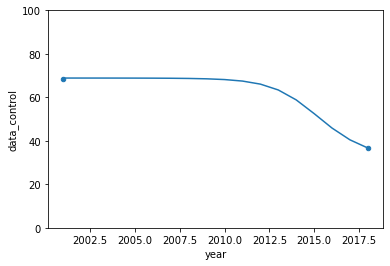

In [47]:
f, ax = plt.subplots()

ax.plot(np.arange(2001, 2019), yf)

control_data_f.plot.scatter(x='year', y='data_control', ax=ax)

ax.set_ylim([0,100])

# Figure

In [54]:
COLZ = sns.color_palette('muted').as_hex()

In [73]:
def figure(fung_data, host_data, yhost, yfung):
    fig = make_subplots(
        rows=2,
        cols=1,
        # shared_xaxes=True,
        # horizontal_spacing=0.33,
    )
    
    col1 = COLZ[1]
    col2 = COLZ[0]
    
    fung_trcs = [
        go.Scatter(
            x=np.arange(fung_data.year.min(), 1+fung_data.year.max()),
            y=yfung,
            showlegend=False,
            line=dict(color=col1),
            mode='lines'
        ),
        go.Scatter(
            x=fung_data.year,
            y=fung_data.data_control,
            showlegend=False,
            marker=dict(color=col2),
            mode='markers'
        )
    ]
    
    fig.add_traces(fung_trcs, rows=1, cols=1)
    
    host_trcs = [
        go.Scatter(
            x=np.arange(host_data.year.min(), 1+host_data.year.max()),
            y=yhost,
            showlegend=False,
            line=dict(color=col1),
            mode='lines'
        ),
        go.Scatter(
            x=host_data.year,
            y=host_data.data_control,
            showlegend=False,
            marker=dict(color=col2),
            mode='markers'
        )
    ]
            
    
    fig.add_traces(host_trcs, rows=2, cols=1)
    
    fig.update_layout(standard_layout(True, height=750))
    fig.update_layout(font=dict(size=14))
    
    col_1 = -0.01
    
    row1 = 1.06
    row2 = 0.49
    
    annotz = [
        
        get_text_annotation(col_1, row1, 'A', size=20),
        get_text_annotation(col_1, row2, 'B', size=20),
        
    ]
    
    fig.update_layout(
        annotations=annotz,
    )
    
    fig.update_xaxes(title_text='Year',
                     row=2, col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Fungicide control (%)',
                     row=1, col=1,
                     range=[0, 100],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Host control (%)',
                     row=2, col=1,
                     range=[0, 100],
                     showgrid=False)
    
    return fig

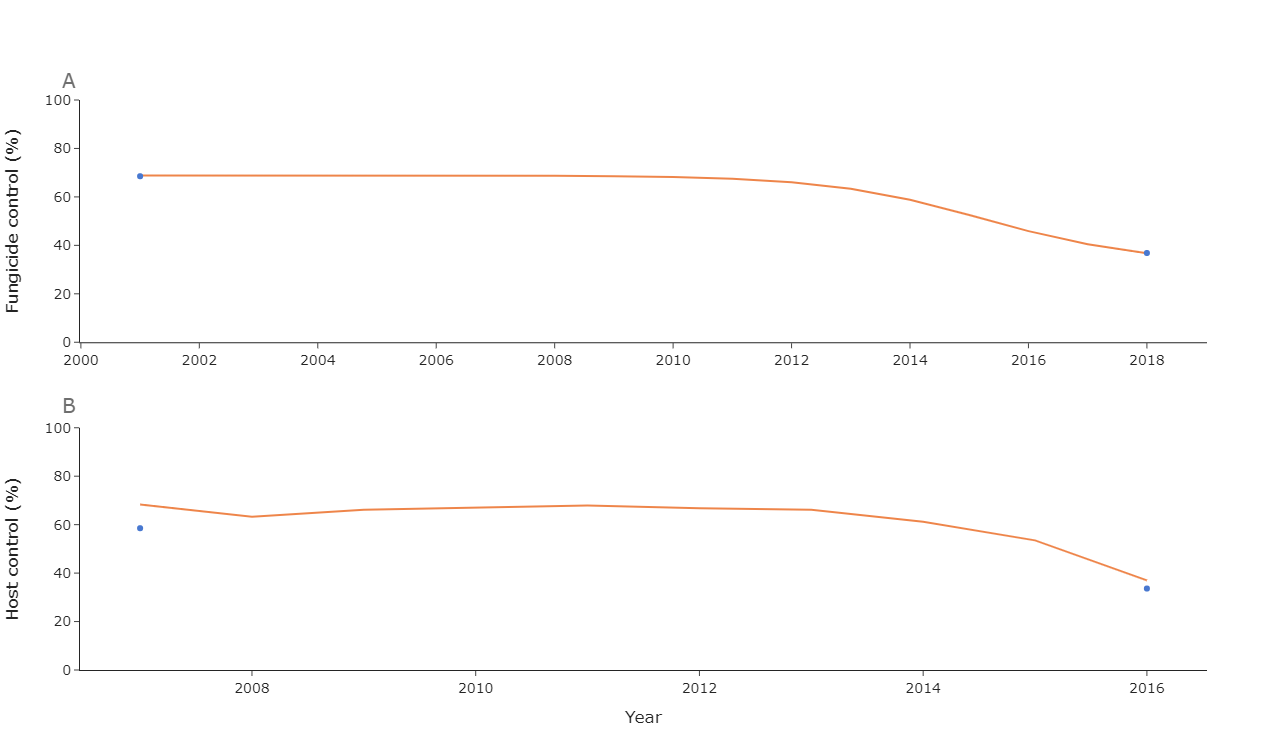

In [74]:
fig = figure(control_data_f, control_data_h, yh, yf)

fig.show()

In [75]:
fig.write_image('../figures/paper_figs/app_mutation_good.png')